# Exploration 15. OCR
---
# (프로젝트) 다양한 OCR모델 비교하기

## [루브릭]
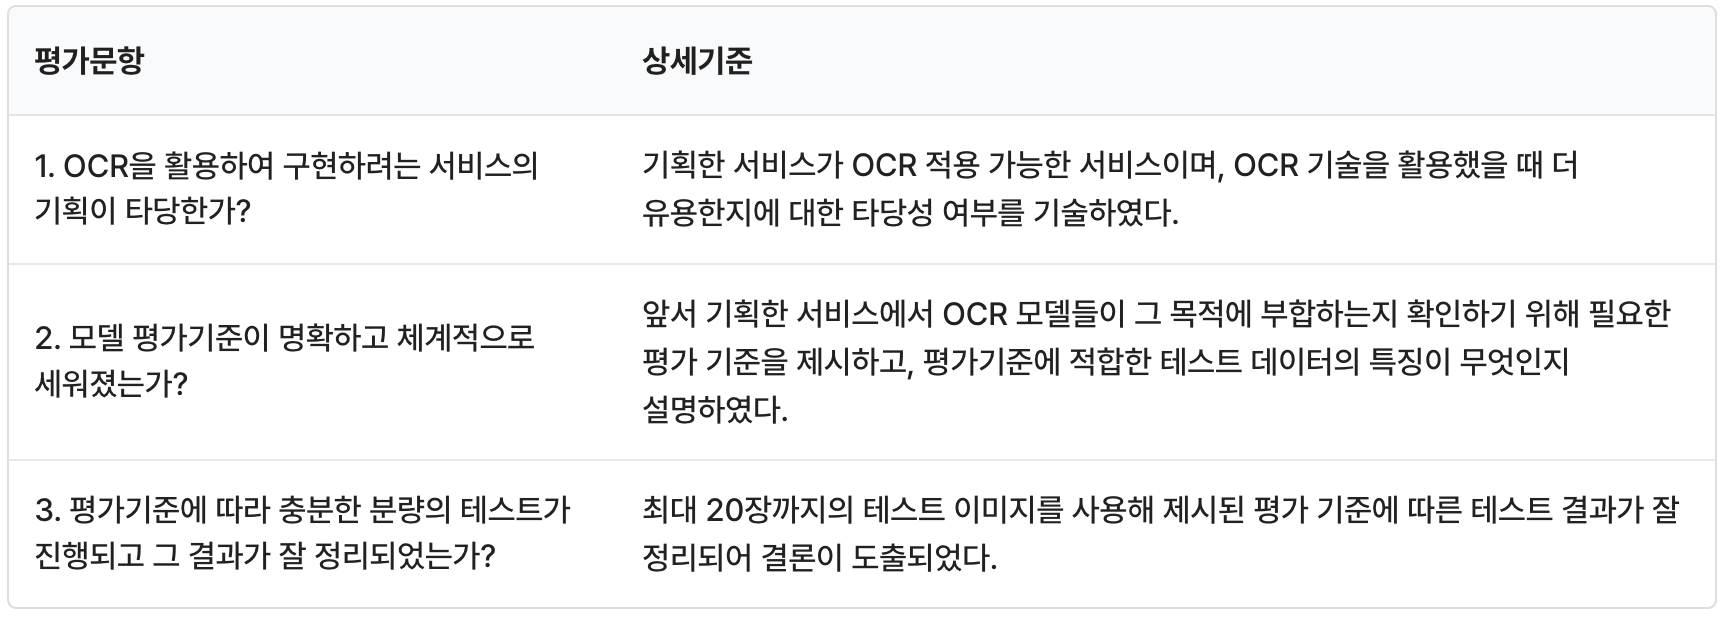

## Step1. 검증용 데이터셋 준비

In [1]:
import os
import matplotlib.pyplot as plt
import cv2

In [2]:
data_path = os.getenv('HOME') + '/aiffel/ocr_python/images'

In [3]:
file_list = os.listdir(data_path)
file_path = [data_path+ '/' +name for name in file_list]

In [4]:
file_path

['/aiffel/aiffel/ocr_python/images/test_6.png',
 '/aiffel/aiffel/ocr_python/images/test_2.png',
 '/aiffel/aiffel/ocr_python/images/test_4.png',
 '/aiffel/aiffel/ocr_python/images/test_1.png',
 '/aiffel/aiffel/ocr_python/images/test_5.png',
 '/aiffel/aiffel/ocr_python/images/.ipynb_checkpoints',
 '/aiffel/aiffel/ocr_python/images/test_7.png',
 '/aiffel/aiffel/ocr_python/images/test_3.png']

In [5]:
del file_path[5]

In [6]:
file_path

['/aiffel/aiffel/ocr_python/images/test_6.png',
 '/aiffel/aiffel/ocr_python/images/test_2.png',
 '/aiffel/aiffel/ocr_python/images/test_4.png',
 '/aiffel/aiffel/ocr_python/images/test_1.png',
 '/aiffel/aiffel/ocr_python/images/test_5.png',
 '/aiffel/aiffel/ocr_python/images/test_7.png',
 '/aiffel/aiffel/ocr_python/images/test_3.png']

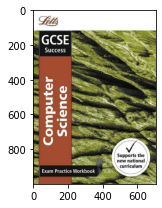

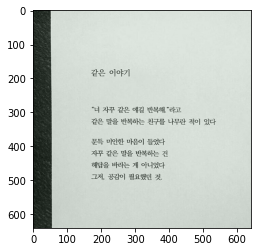

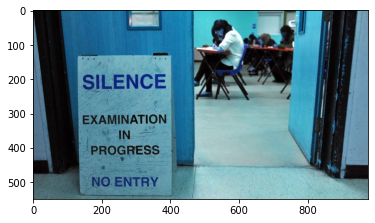

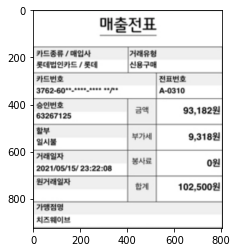

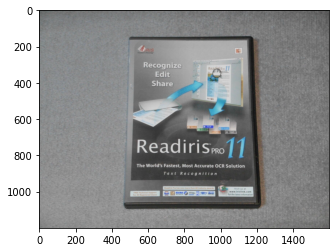

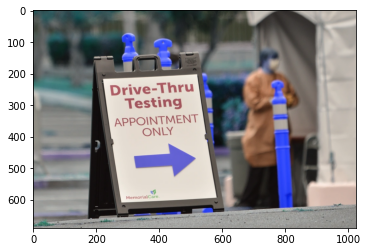

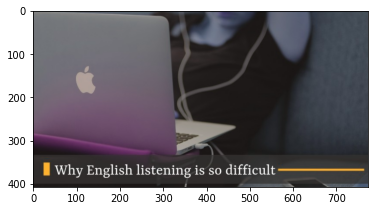

In [7]:
fig = plt.figure(figsize=(40,30))
for idx, path in enumerate(file_path, 1):
    ax = fig.add_subplot(8, 1, idx)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    plt.imshow(img)
    
    plt.show()

In [8]:
import keras_ocr
import pytesseract

print(keras_ocr.__version__)
print(pytesseract.__version__)
# pytesseract는 tesseract-ocr에 종속적입니다. 아래 명령어를 통해 설치해야 할 수도 있습니다.
# !sudo apt install tesseract-ocr

0.8.8
0.3.8


## Step2. 테스트 진행

### Google OCR API

In [9]:
def detect_text(path):
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()
    
    with io.open(path, 'rb') as image_file:
        content = image_file.read()
    
    image = vision.Image(content=content)
    
    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    #     for text in texts:
    print('\n"{}"'.format(texts[0].description))
    
    vertices = (['({},{})'.format(vertex.x, vertex.y) for vertex in texts[0].bounding_poly.vertices])
    
    print('bounds: {}'.format(','.join(vertices)))
    
    if response.error.message:
        raise Exception(
        '{}\nFor more info on erroe messages, check:' 
        'https://cloud.google.com/apis/design/errors'.format(
        response.error.message))
    
    return texts[0].description

In [10]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = os.getenv('HOME') + '/aiffel/ocr_python/my_google_api_key.json'

In [11]:
google_ocr_result = []

In [12]:
for path in file_path:
    result = detect_text(path)
    google_ocr_result.extend(result)

/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


Texts:

"Letts
GCSE
Success
Computer
Science
Exam Practice Workbook
Supports the
new national
curriculum"
bounds: (31,38),(642,38),(642,935),(31,935)
Texts:

"같은 이야기
“너 자꾸 같은 얘길 반복해."라고
같은 말을 반복하는 친구를 나무란 적이 있다
문득 미안한 마음이 들었다
자꾸 같은 말을 반복하는 건
해답을 바라는 게 아니었다
그저, 공감이 필요했던 것."
bounds: (169,173),(537,173),(537,499),(169,499)
Texts:

"SILENCE
EXAMINATION
IN
PROGRESS
NO. ENTRY
AS"
bounds: (145,185),(387,185),(387,516),(145,516)
Texts:

"카드종류 / 매입사
롯데법인카드 / 롯데
카드번호
3762-60......
승인번호
63267125
할부
일시불
거래일자
매출전표
2021/05/15/23:22:08
원거래일자
가맹점명
치즈웨이브
거래유형
신용구매
금액
부가세
봉사료
합계
전표번호
A-0310
93,182원
9,318원
0원
102,500원"
bounds: (11,32),(794,32),(794,905),(11,905)
Texts:

"IRIS
Recognize
Edit
Share
Word
FREE Technical Support
For All Registered Users!
Readis 11
PDF
Excell
SVM
*****
De-mail
HTML
Readiris PRO 11
The World's Fastest, Most Accurate OCR Solution
Text Recognition
Readiris Pro has won more than 80 industry awards
design, p
*****
Text
Visit us at
www.irislink.com
for the latest information"
bounds

## keras-ocr

In [13]:
import keras_ocr

In [14]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [15]:
images = [keras_ocr.tools.read(path) for path in file_path]

In [16]:
prediction_groups = [pipeline.recognize({path}) for path in file_path]

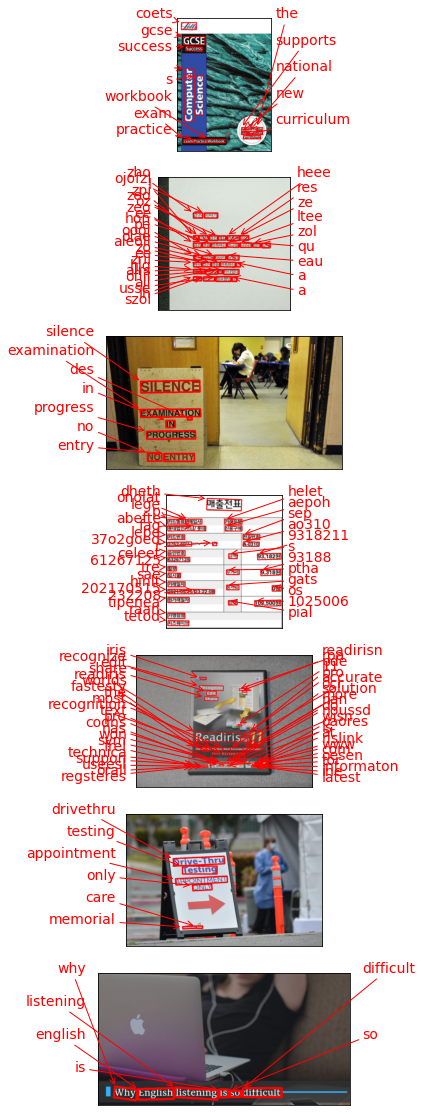

In [17]:
fig, axs = plt.subplots(nrows=len(images), figsize=(30,20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], predictions=prediction_groups[idx][0], ax=ax)

## Tesseract

In [18]:
import pytesseract
from PIL import Image
from pytesseract import Output

In [19]:
def crop_word_regions(image_path, output_path='./output', lang='kor'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)
    
    recognized_data = pytesseract.image_to_data(
        image, lang=lang,
        config=custom_oem_psm_config,
        output_type=Output.DICT)
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
        
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f'{str(index).zfill(4)}.png')
            cropped_image = image.crop((
                left, top, left+width, top+height))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [20]:
work_dir = os.getenv('HOME') + '/aiffel/ocr_python/tesseract/kor'

In [21]:
tesseract_result_path = []
for path in file_path:
    image_path_list = crop_word_regions(path, work_dir)
    tesseract_result_path.extend(image_path_list)

In [22]:
def recognized_images(cropped_image_path_list, lang='kor'):
    custom_oem_psm_config = r' --oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang=lang,
            config=custom_oem_psm_config,
            output_type=Output.DICT)
        print(recognized_data['text'])
    print('Done')

In [23]:
recognized_images(tesseract_result_path)


!

어드

로

=

ｌ

211

개)

|

익


01]

|

10

용

|

니버

10.

0

+

。

11

|

[

다드00이 음은0 에


!

어드

로

=

ｌ

211

개)

|

익


01]

|

10

용

|

니버

10.

0

+

。

11

|

[

다드00이 음은0 에

1

-드*

@

도,

[1


를 은,


~,

(7

6

"

| 0

1]


]

0,

세

 :

6

바라는 게

거

아니었다

그저.

토고

감


픈

[0

었던

점


!

어드

로

=

ｌ

211

개)

|

익


01]

|

10

용

|

니버

10.

0


!

어드

로

=

ｌ

211

개)

|

익


01]

|

10

용

|

니버

10.

0

+

。

11

|

[

다드00이 음은0 에

1

-드*

@

도,

[1


를 은,


~,

(7

6

"

| 0

1]


]

0,

세


!

어드

로

=

ｌ

211

개)

|

익


01]

|

10

용

|

니버

10.

0

+

。

11

|

[

다드00이 음은0 에

1

-드*

@

도,

[1


를 은,


~,

(7

6

"

| 0

1]


]

0,

세

 :


!

어드

로

=

ｌ

211

개)

|

익



!

어드

로

=

ｌ

211

개)

|

익


01]

|

10

용

|

니버

10.

0

+

。

11

|

[


In [24]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/tesseract/eng'

In [25]:
tesseract_result_path = []

In [26]:
for path in file_path:
    image_path_list = crop_word_regions(path, work_dir, lang='eng')
    tesseract_result_path.extend(image_path_list)

In [27]:
recognized_images(image_path_list, lang='eng')


I

Why English

hte

ning |

ase

Keltaa

Canis

— Sl

Done


## Step3. 테스트 결과 정리


In [30]:
def ocr_model_comparison(img_idx):
    print('Original image:')
    img = cv2.imread(file_path[img_idx], cv2.IMREAD_COLOR)
    plt.imshow(img)
    plt.show()
    
    print('Google OCR API resule:\n')
    detect_text(file_path[img_idx])
    
    print('Tesseract result:\n')
    work_dir = os.getenv('HOME') + '/aiffel/ocr_python/tesseract/'+str(img_idx)
    cropped_image_path = crop_word_regions(file_path[img_idx], work_dir)
    recognized_images(cropped_image_path)
    
    print('keras-ocr result:\n')
    keras_ocr.tools.drawAnnotations(image=images[img_idx], predictions=prediction_groups[img_idx][0])

Original image:


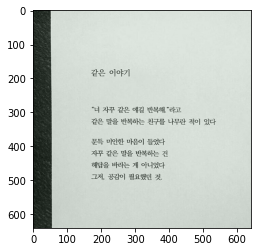

Google OCR API resule:

Texts:

"같은 이야기
“너 자꾸 같은 얘길 반복해."라고
같은 말을 반복하는 친구를 나무란 적이 있다
문득 미안한 마음이 들었다
자꾸 같은 말을 반복하는 건
해답을 바라는 게 아니었다
그저, 공감이 필요했던 것."
bounds: (169,173),(537,173),(537,499),(169,499)
Tesseract result:

이야기

7

고른

디노

3

자수

같은

애길

반느

8


1

라고

고

같은

막을


바

복구

하는

진

구는

~”

나

무근


적이

있다

순득

미안한

|

[노즈

0

| 늘었

자꾸

같은

104 +-~

수

반느

(

[는

건

해

"답:

6

바라는 게

거

아니었다

그저.

토고

감


픈

[0

었던

점

Done
keras-ocr result:



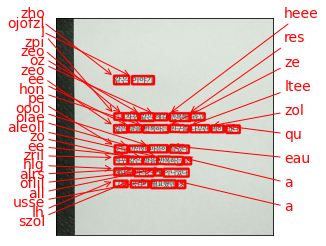

In [31]:
ocr_model_comparison(1)

Original image:


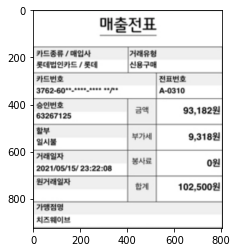

Google OCR API resule:

Texts:

"카드종류 / 매입사
롯데법인카드 / 롯데
카드번호
3762-60......
승인번호
63267125
할부
일시불
거래일자
매출전표
2021/05/15/23:22:08
원거래일자
가맹점명
치즈웨이브
거래유형
신용구매
금액
부가세
봉사료
합계
전표번호
A-0310
93,182원
9,318원
0원
102,500원"
bounds: (11,32),(794,32),(794,905),(11,905)
Tesseract result:

매출


+

4

카

르

종류

1”

「매

입^

나

거2

>

(유헝

로

데분

법

인

!카드

/

롯데

신

봄 ,

;구매

카드

1!

-번호

전조

1

[번호

7762.60“ “6

0000

/

22.0310

레

: 떼메

9.91

8원

봉사료              0원

게

102,500원

원


Done
keras-ocr result:



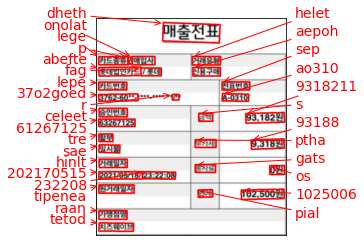

In [32]:
ocr_model_comparison(3)

Original image:


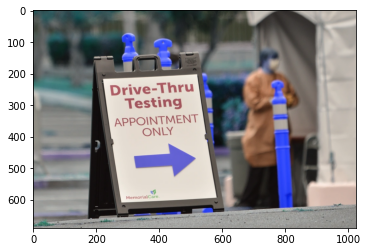

Google OCR API resule:

Texts:

"Drive-Thru
Testing
APPOINTMENT
ONLY
Memorial Care."
bounds: (241,224),(526,224),(526,598),(241,598)
Tesseract result:

1) 남

깅즌- | 두레

466

@-1

러

남료

니

그

-

다이


Done
keras-ocr result:



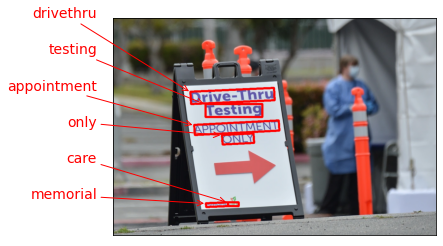

In [33]:
ocr_model_comparison(5)

## Step4. 결과 분석

전반적으로 Google OCR API의 경우 인식에 대한 정확도도 높고 정리 또한 깔끔하게 처리하여 제공해 주었습니다. Tesseract의 경우 전체적으로 인식이 부정확한 것이 확인되며, keras-ocr의 경우 정확도는 떨어지나 텍스트가 있는 위치는 잘 찾아 내는 것 같습니다. 

[참고]  
 - https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=7caf426bd7b23b7164faeb3d9c43679b8382b241&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d69696e6b616e672f41495f50726f6a6563745f41494646454c2f376361663432366264376232336237313634666165623364396334333637396238333832623234312f253542452d31382535444f43522e6970796e62&logged_in=false&nwo=miinkang%2FAI_Project_AIFFEL&path=%5BE-18%5DOCR.ipynb&platform=android&repository_id=326871371&repository_type=Repository&version=105